In [ ]:
import pandas as pd
from pathlib import Path
import sys
import logging
from tqdm.notebook import tqdm
import json
from sklearn.feature_extraction.text import CountVectorizer
tqdm.pandas()

# --- Configurar Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# --- 1. Configuración de Rutas y Constantes ---
ROOT = Path.cwd().parent
DATA_DIR_PROCESSED = ROOT / "data" / "02_processed"
DATA_DIR_FINAL = ROOT / "data" / "03_final"

ANALYTICAL_DIR = DATA_DIR_FINAL / "analytical_dataset.parquet"
STANCE_DIR = DATA_DIR_PROCESSED / "dialogue_master_clean.parquet"

In [ ]:
df = pd.read_parquet(ANALYTICAL_DIR)
df.head(3)

,votacion_id,fecha_votacion,total_si,total_no,total_abstenciones,total_dispensado,quorum,diputado_id,voto_valor,boletin_id,...,etapa,leynro,autores_json,boletin_id_consultado,topic_materia,topic_titulo,topic_materia_id,topic_materia_nombre,topic_titulo_id,topic_titulo_nombre
0,14898,2002-12-19 12:06:00,65,0,0,0,Quórum Simple,800,1,2625-07,...,Tramitación terminada,Ley Nº 19.866,"[""R\u00edos Santander, Mario""]",2625.0,9.0,8.0,-1.0,-1_sector_público_remuneraciones_salud,10.0,10_viviendas_urbanismo_construcciones_raíces
1,14898,2002-12-19 12:06:00,65,0,0,0,Quórum Simple,802,1,2625-07,...,Tramitación terminada,Ley Nº 19.866,"[""R\u00edos Santander, Mario""]",2625.0,9.0,8.0,-1.0,-1_sector_público_remuneraciones_salud,10.0,10_viviendas_urbanismo_construcciones_raíces
2,14898,2002-12-19 12:06:00,65,0,0,0,Quórum Simple,807,1,2625-07,...,Tramitación terminada,Ley Nº 19.866,"[""R\u00edos Santander, Mario""]",2625.0,9.0,8.0,-1.0,-1_sector_público_remuneraciones_salud,10.0,10_viviendas_urbanismo_construcciones_raíces


In [ ]:
df_stance = pd.read_parquet(STANCE_DIR)
df_stance.head(3)

,nombre_dip,text,source_file,fecha_completa,fecha_datetime,speaker_type,sexo,numero_legislatura,numero_sesion,boletin_rescatado,...,topics_boletines,boletin_inferido,titulo_final,topico_final,postura_titulo_final,promedio_stance_boletin,postura_promedio_boletin_cat,prediccion_id,text_titulo,prediccion_titulo_id
0,Juan Bustos Ramírez,"El señor BUSTOS.- Señora Presidenta, la reform...",C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,male,346,10,2852-07,...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,A Favor,0.983699,A Favor,0,Contexto: Crea nuevas salas en las Cortes de A...,0
1,José Miguel Ortiz Novoa,"El señor ORTIZ.- Señora Presidenta, el día de ...",C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,male,346,10,2852-07,...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,Neutral,0.141427,Neutral,0,Contexto: Crea nuevas salas en las Cortes de A...,0
2,Edgardo Riveros Marín,"El señor RIVEROS.- Señora Presidenta, comparti...",C:/Users/conjv/Desktop/boletines_json/legislat...,10-04-2002 10:36:00,2002-04-10,Diputado,male,346,10,2852-07,...,13_monumento_autoriza_memoria_erigir,2852-07,Crea nuevas salas en las Cortes de Apelaciones...,13_monumento_autoriza_memoria_erigir,A Favor,0.761392,A Favor,2,Contexto: Crea nuevas salas en las Cortes de A...,2


## Primer entrenamiento, dataFrame completo

In [ ]:
df.columns

Index(['votacion_id', 'fecha_votacion', 'total_si', 'total_no',
       'total_abstenciones', 'total_dispensado', 'quorum', 'diputado_id',
       'voto_valor', 'boletin_id', 'periodo', 'sesion', 'sesion_id',
       'resultado_general', 'tipo_votacion', 'tipo_sesion', 'tramite',
       'informe', 'partido_id', 'periodo_fecha_inicio',
       'militancia_fecha_inicio', 'militancia_fecha_termino',
       'nombre_completo', 'sexo', 'fecha_nacimiento', 'edad_inicio_periodo',
       'rango_etario', 'estado_civil', 'numero_hijos', 'pais_nacimiento',
       'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
       'universidad_tipo', 'carrera_primaria', 'carrera_secundaria',
       'colegio_merge_key', 'nombre_padre_raw', 'nombre_madre_raw',
       'dependencia_colegio', 'dependencia_etiqueta',
       'antiguedad_partido_anios', 'indice_rice', 'voto_bancada',
       'voto_con_bancada', 'disciplina_partidaria_hist', 'titulo',
       'fecha_ingreso', 'iniciativa', 'camara_origen', 

In [ ]:
df['fecha_votacion'] = pd.to_datetime(df['fecha_votacion'], errors='coerce')
df = df.sort_values('fecha_votacion').reset_index(drop=True)

In [ ]:
df_model = df[['diputado_id',
              'indice_rice',
              'disciplina_partidaria_hist',
              'dependencia_colegio',
              'topic_titulo_id',
              'voto_valor',
              'quorum',
              'periodo', 'tipo_votacion', 'tipo_sesion', 'tramite',
              'informe', 'partido_id',
              'sexo',
              'rango_etario', 'estado_civil', 'numero_hijos', 'pais_nacimiento',
              'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
              'universidad_tipo', 'carrera_primaria',
              'iniciativa', 'camara_origen', 'etapa']].copy()

In [ ]:
NUMERICAL_FEATURES = ['indice_rice',
                      'disciplina_partidaria_hist',
                      'numero_hijos'
                      ]

CATEGORICAL_FEATURES = ['quorum',
       'periodo', 'tipo_votacion', 'tipo_sesion',
       'partido_id', 'dependencia_colegio',
       'topic_titulo_id', 'sexo',
       'rango_etario', 'estado_civil', 'pais_nacimiento',
       'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
       'universidad_tipo', 'carrera_primaria',
        'iniciativa', 'camara_origen']

In [ ]:
df_model.isna().sum().sort_values(ascending=False)

,0
numero_hijos,368814
dependencia_colegio,112181
educacion_nivel,99424
distrito,19710
indice_rice,19439
sexo,19355
pais_nacimiento,19355
partido_id,19355
rango_etario,19355
estado_civil,19355


In [ ]:
df_model['numero_hijos_is_null'] = df_model['numero_hijos'].isna().astype(int)
df_model['numero_hijos'] = df_model['numero_hijos'].fillna(df_model['numero_hijos'].median())

In [ ]:
df_model = df_model.dropna()
df_model = df_model[df_model["voto_valor"].isin([0, 1])]
df_model = df_model[df_model["tipo_votacion"] == "Particular"]

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop(["voto_valor"], axis=1)
y = df_model["voto_valor"]

# Dividir los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocesamiento = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES),
        ('num', StandardScaler(), NUMERICAL_FEATURES)
    ]
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "CatBoost" : CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function="Logloss",
    task_type="GPU",           # o "CPU" si no tienes GPU
),
    "XGBoost": XGBClassifier(scale_pos_weight=1)
}

In [ ]:
from sklearn.pipeline import Pipeline

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocess', preprocesamiento),
        ('model', model)
    ])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

results = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results[name] = classification_report(y_test, preds)

results

0:	learn: 0.6776238	total: 36ms	remaining: 17.9s
1:	learn: 0.6636118	total: 62.2ms	remaining: 15.5s
2:	learn: 0.6510709	total: 87.8ms	remaining: 14.5s
3:	learn: 0.6397234	total: 114ms	remaining: 14.2s
4:	learn: 0.6298107	total: 140ms	remaining: 13.9s
5:	learn: 0.6209218	total: 166ms	remaining: 13.7s
6:	learn: 0.6125883	total: 192ms	remaining: 13.5s
7:	learn: 0.6054196	total: 217ms	remaining: 13.4s
8:	learn: 0.5987316	total: 239ms	remaining: 13s
9:	learn: 0.5930285	total: 256ms	remaining: 12.5s
10:	learn: 0.5875841	total: 274ms	remaining: 12.2s
11:	learn: 0.5826368	total: 292ms	remaining: 11.9s
12:	learn: 0.5784492	total: 309ms	remaining: 11.6s
13:	learn: 0.5746252	total: 326ms	remaining: 11.3s
14:	learn: 0.5712755	total: 343ms	remaining: 11.1s
15:	learn: 0.5680709	total: 359ms	remaining: 10.9s
16:	learn: 0.5651302	total: 376ms	remaining: 10.7s
17:	learn: 0.5626868	total: 392ms	remaining: 10.5s
18:	learn: 0.5603030	total: 409ms	remaining: 10.4s
19:	learn: 0.5580211	total: 428ms	remainin

{'Logistic Regression': '              precision    recall  f1-score   support\n\n           0       0.39      0.62      0.48     53836\n           1       0.82      0.63      0.71    143507\n\n    accuracy                           0.63    197343\n   macro avg       0.60      0.63      0.59    197343\nweighted avg       0.70      0.63      0.65    197343\n',
 'CatBoost': '              precision    recall  f1-score   support\n\n           0       0.72      0.25      0.38     53836\n           1       0.77      0.96      0.86    143507\n\n    accuracy                           0.77    197343\n   macro avg       0.75      0.61      0.62    197343\nweighted avg       0.76      0.77      0.73    197343\n',
 'XGBoost': '              precision    recall  f1-score   support\n\n           0       0.71      0.26      0.38     53836\n           1       0.78      0.96      0.86    143507\n\n    accuracy                           0.77    197343\n   macro avg       0.74      0.61      0.62    197

In [ ]:
print(results['CatBoost'])

              precision    recall  f1-score   support

           0       0.72      0.25      0.38     53836
           1       0.77      0.96      0.86    143507

    accuracy                           0.77    197343
   macro avg       0.75      0.61      0.62    197343
weighted avg       0.76      0.77      0.73    197343



In [ ]:
print(results['Logistic Regression'])

              precision    recall  f1-score   support

           0       0.39      0.62      0.48     53836
           1       0.82      0.63      0.71    143507

    accuracy                           0.63    197343
   macro avg       0.60      0.63      0.59    197343
weighted avg       0.70      0.63      0.65    197343



In [ ]:
print(results['XGBoost'])

              precision    recall  f1-score   support

           0       0.71      0.26      0.38     53836
           1       0.78      0.96      0.86    143507

    accuracy                           0.77    197343
   macro avg       0.74      0.61      0.62    197343
weighted avg       0.76      0.77      0.73    197343



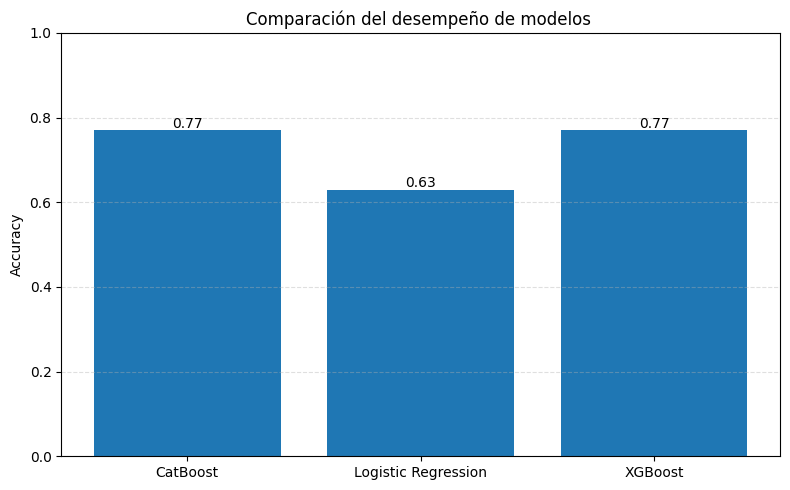

In [ ]:
import matplotlib.pyplot as plt

# Resultados (puedes cambiarlos si obtienes nuevos)
f1_scores = {
    "CatBoost": 0.77,
    "Logistic Regression": 0.63,
    "XGBoost": 0.77
}

modelos = list(f1_scores.keys())
scores = list(f1_scores.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(modelos, scores)

# Mostrar valor encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2f}", ha='center')

plt.title("Comparación del desempeño de modelos ")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # escala 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

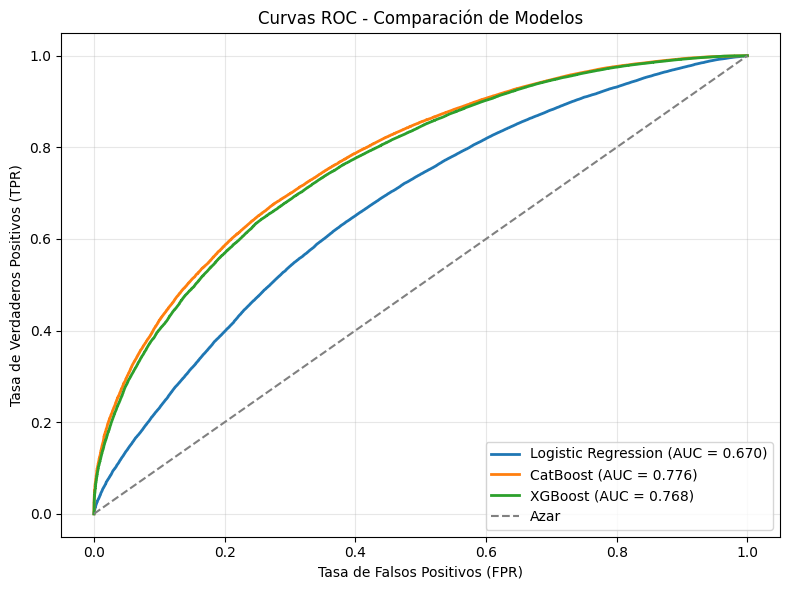

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, pipe in pipelines.items():
    # Probabilidades de clase positiva
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:  # Algunos modelos pueden usar decision_function
        y_prob = pipe.decision_function(X_test)

    # Valores para ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Graficar curva
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Línea aleatoria
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Azar")

plt.title("Curvas ROC - Comparación de Modelos")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("curvas_ROC_modelos.png", dpi=300)
plt.show()

## Análisis SHAP XGBoost

In [ ]:
def get_feature_names_from_column_transformer(ct):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)
    return feature_names

preprocess = pipe.named_steps["preprocess"]
feature_names = get_feature_names_from_column_transformer(preprocess)

In [ ]:
pipe = pipelines["XGBoost"]       # ejemplo
pipe.fit(X_train, y_train)
model = pipe.named_steps["model"]  # modelo ya entrenado
X_test_trans = pipe.named_steps["preprocess"].transform(X_test)

X_test_df = pd.DataFrame(X_test_trans.toarray(), columns=feature_names)

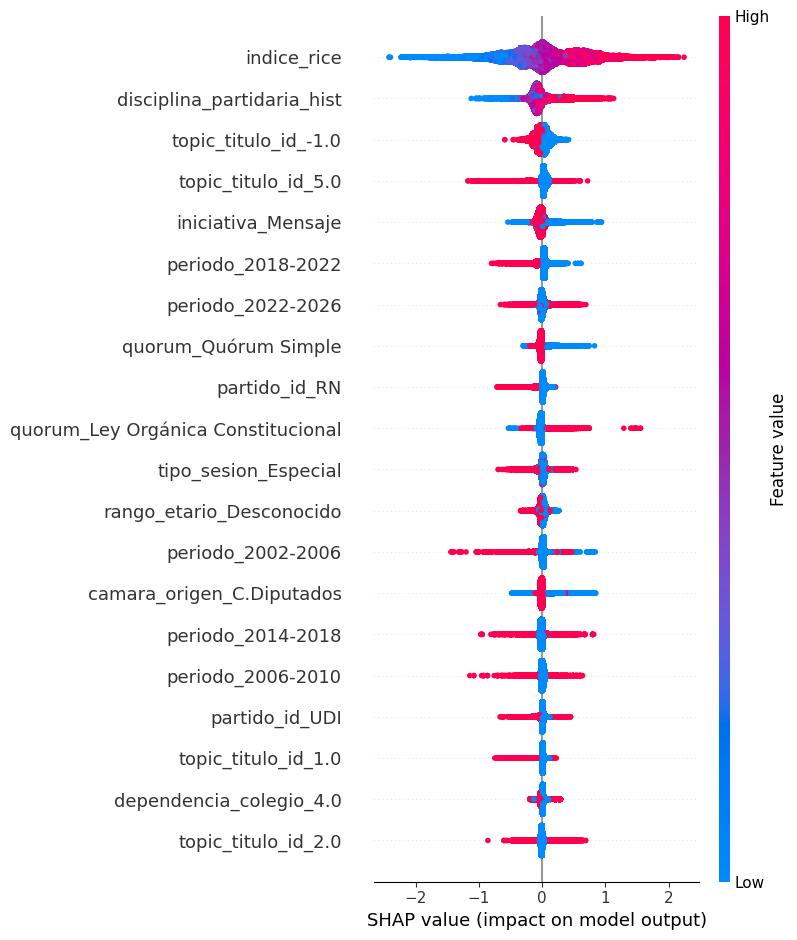

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)

shap.summary_plot(shap_values, X_test_df, feature_names=X_test_df.columns)
plt.tight_layout()
plt.show()

In [ ]:
explainer = shap.TreeExplainer(
    model,
    feature_perturbation="interventional"
)

shap_inter = explainer.shap_interaction_values(X_test_trans)

shap.summary_plot(shap_inter, X_test_df, feature_names=X_test_df.columns)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:254: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


In [ ]:
df[['topic_titulo_id', 'topic_titulo_nombre']].drop_duplicates()

,topic_titulo_id,topic_titulo_nombre
0,12.0,12_pesca_acuicultura_artesanal_general
58,11.0,11_chile_carabineros_gendarmería_personal
344,1.0,1_constitucional_orgánica_electoral_18
416,-1.0,-1_ley_modifica_crea_establece
477,2.0,2_fondos_pensiones_tributario_tributaria
672,14.0,14_trabajo_código_trabajadores_laboral
749,13.0,13_monumento_autoriza_memoria_erigir
907,0.0,0_penal_delitos_código_delito
1317,NaN,None
2220,8.0,8_salud_sanitario_atención_servicios


## Entrenamiento con stance detection

In [ ]:
df_model = df.merge(df_stance, left_on=['boletin_id', 'nombre_completo'],
                    right_on=['boletin_inferido', 'nombre_dip'],
                    how='inner').rename(columns={'prediccion_titulo_id' : 'stance_id'})

In [ ]:
df_model['fecha_votacion'] = pd.to_datetime(df_model['fecha_votacion'], errors='coerce')
df_model = df_model.sort_values('fecha_votacion').reset_index(drop=True)

In [ ]:
df_model = df_model[['diputado_id',
              'indice_rice',
              'disciplina_partidaria_hist',
              'dependencia_colegio',
              'topic_titulo_id',
              'voto_valor',
              'quorum',
              'periodo', 'tipo_votacion', 'tipo_sesion', 'tramite',
              'informe', 'partido_id',
              'rango_etario', 'estado_civil', 'numero_hijos', 'pais_nacimiento',
              'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
              'universidad_tipo', 'carrera_primaria',
              'iniciativa', 'camara_origen', 'etapa', 'stance_id']].copy()

In [ ]:
NUMERICAL_FEATURES = ['indice_rice',
                      'disciplina_partidaria_hist',
                      'numero_hijos'
                      ]

CATEGORICAL_FEATURES = ['quorum',
       'periodo', 'tipo_votacion', 'tipo_sesion',
       'partido_id', 'dependencia_colegio',
       'topic_titulo_id',
       'rango_etario', 'estado_civil', 'pais_nacimiento',
       'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
       'universidad_tipo', 'carrera_primaria',
        'iniciativa', 'camara_origen', 'stance_id']

In [ ]:
df_model.isna().sum().sort_values(ascending=False)

,0
numero_hijos,186786
educacion_nivel,52122
dependencia_colegio,50527
camara_origen,43908
etapa,43908
topic_titulo_id,43908
iniciativa,43908
tramite,14243
tipo_votacion,14243
informe,14243


In [ ]:
df_model['numero_hijos_is_null'] = df_model['numero_hijos'].isna().astype(int)
df_model['numero_hijos'] = df_model['numero_hijos'].fillna(df_model['numero_hijos'].median())

In [ ]:
df_model = df_model.dropna()
df_model = df_model[df_model["voto_valor"].isin([0, 1])]
df_model = df_model[df_model["tipo_votacion"] == "Particular"]

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop(["voto_valor"], axis=1)
y = df_model["voto_valor"]

# Dividir los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocesamiento = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES),
        ('num', StandardScaler(), NUMERICAL_FEATURES)
    ]
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "CatBoost" : CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function="Logloss",
    task_type="GPU",           # o "CPU" si no tienes GPU
),
    "XGBoost": XGBClassifier(scale_pos_weight=1)
}

In [ ]:
from sklearn.pipeline import Pipeline

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocess', preprocesamiento),
        ('model', model)
    ])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

results = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results[name] = classification_report(y_test, preds)

results

0:	learn: 0.6774594	total: 21.5ms	remaining: 10.7s
1:	learn: 0.6632289	total: 42.4ms	remaining: 10.6s
2:	learn: 0.6501058	total: 64.4ms	remaining: 10.7s
3:	learn: 0.6385122	total: 84.8ms	remaining: 10.5s
4:	learn: 0.6283993	total: 106ms	remaining: 10.5s
5:	learn: 0.6192741	total: 126ms	remaining: 10.4s
6:	learn: 0.6106997	total: 147ms	remaining: 10.4s
7:	learn: 0.6033890	total: 169ms	remaining: 10.4s
8:	learn: 0.5966069	total: 190ms	remaining: 10.4s
9:	learn: 0.5905733	total: 207ms	remaining: 10.1s
10:	learn: 0.5853742	total: 223ms	remaining: 9.93s
11:	learn: 0.5805921	total: 239ms	remaining: 9.71s
12:	learn: 0.5762759	total: 254ms	remaining: 9.52s
13:	learn: 0.5720902	total: 271ms	remaining: 9.4s
14:	learn: 0.5680589	total: 287ms	remaining: 9.29s
15:	learn: 0.5649606	total: 303ms	remaining: 9.16s
16:	learn: 0.5621529	total: 318ms	remaining: 9.04s
17:	learn: 0.5595108	total: 333ms	remaining: 8.92s
18:	learn: 0.5572963	total: 346ms	remaining: 8.76s
19:	learn: 0.5551409	total: 359ms	rema

{'Logistic Regression': '              precision    recall  f1-score   support\n\n           0       0.41      0.66      0.51     37488\n           1       0.83      0.64      0.72     97158\n\n    accuracy                           0.64    134646\n   macro avg       0.62      0.65      0.61    134646\nweighted avg       0.71      0.64      0.66    134646\n',
 'CatBoost': '              precision    recall  f1-score   support\n\n           0       0.71      0.26      0.38     37488\n           1       0.77      0.96      0.85     97158\n\n    accuracy                           0.76    134646\n   macro avg       0.74      0.61      0.62    134646\nweighted avg       0.75      0.76      0.72    134646\n',
 'XGBoost': '              precision    recall  f1-score   support\n\n           0       0.70      0.27      0.39     37488\n           1       0.77      0.96      0.85     97158\n\n    accuracy                           0.77    134646\n   macro avg       0.74      0.61      0.62    134

In [ ]:
print(results['CatBoost'])

              precision    recall  f1-score   support

           0       0.71      0.26      0.38     37488
           1       0.77      0.96      0.85     97158

    accuracy                           0.76    134646
   macro avg       0.74      0.61      0.62    134646
weighted avg       0.75      0.76      0.72    134646



In [ ]:
print(results['Logistic Regression'])

              precision    recall  f1-score   support

           0       0.41      0.66      0.51     37488
           1       0.83      0.64      0.72     97158

    accuracy                           0.64    134646
   macro avg       0.62      0.65      0.61    134646
weighted avg       0.71      0.64      0.66    134646



In [ ]:
print(results['XGBoost'])

              precision    recall  f1-score   support

           0       0.70      0.27      0.39     37488
           1       0.77      0.96      0.85     97158

    accuracy                           0.77    134646
   macro avg       0.74      0.61      0.62    134646
weighted avg       0.75      0.77      0.73    134646



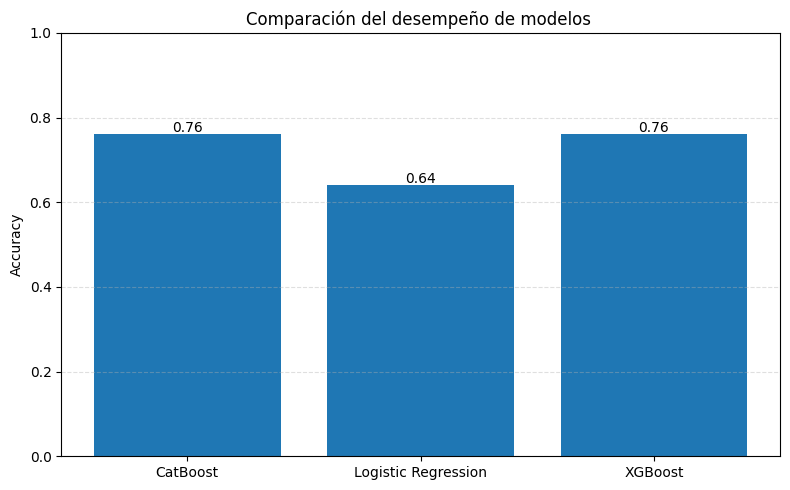

In [ ]:
import matplotlib.pyplot as plt

# Resultados (puedes cambiarlos si obtienes nuevos)
f1_scores = {
    "CatBoost": 0.76,
    "Logistic Regression": 0.64,
    "XGBoost": 0.76
}

modelos = list(f1_scores.keys())
scores = list(f1_scores.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(modelos, scores)

# Mostrar valor encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2f}", ha='center')

plt.title("Comparación del desempeño de modelos ")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # escala 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Visualización SHAP XGBoost + Stance Detection

In [ ]:
def get_feature_names_from_column_transformer(ct):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)
    return feature_names

preprocess = pipe.named_steps["preprocess"]
feature_names = get_feature_names_from_column_transformer(preprocess)

In [ ]:
pipe = pipelines["XGBoost"]       # ejemplo
pipe.fit(X_train, y_train)
model = pipe.named_steps["model"]  # modelo ya entrenado
X_test_trans = pipe.named_steps["preprocess"].transform(X_test)

X_test_df = pd.DataFrame(X_test_trans.toarray(), columns=feature_names)

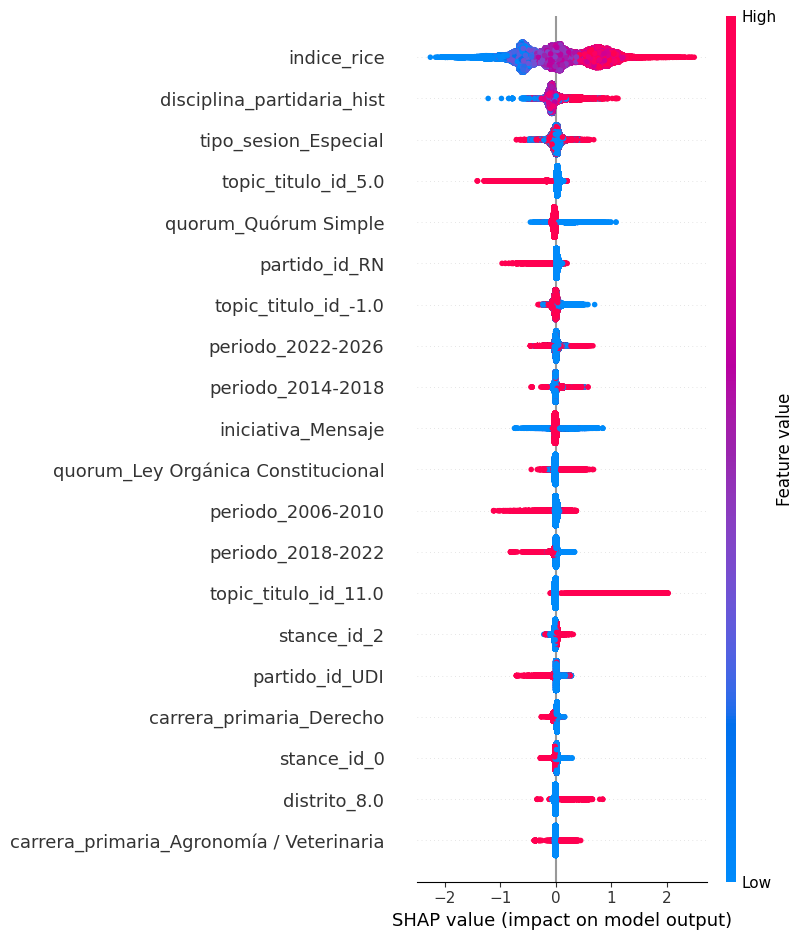

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)

shap.summary_plot(shap_values, X_test_df, feature_names=X_test_df.columns)
plt.tight_layout()
plt.show()

## Entrenamiento por períodos

In [ ]:
resultados_periodos = {}

for periodo in df_model["periodo"].unique():
    df_periodo = df_model[df_model["periodo"] == periodo]
    X = df_periodo.drop(["voto_valor"], axis=1)
    y = df_periodo["voto_valor"]

    # Dividir los datos en conjuntos de entrenamiento y prueba

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    results = {}

    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        results[name] = classification_report(y_test, preds)

    resultados_periodos[periodo] = results

0:	learn: 0.6673542	total: 200ms	remaining: 1m 39s
1:	learn: 0.6448023	total: 303ms	remaining: 1m 15s
2:	learn: 0.6240679	total: 404ms	remaining: 1m 7s
3:	learn: 0.6053378	total: 498ms	remaining: 1m 1s
4:	learn: 0.5881900	total: 590ms	remaining: 58.4s
5:	learn: 0.5747728	total: 682ms	remaining: 56.1s
6:	learn: 0.5613222	total: 772ms	remaining: 54.4s
7:	learn: 0.5512599	total: 863ms	remaining: 53.1s
8:	learn: 0.5424403	total: 952ms	remaining: 52s
9:	learn: 0.5320624	total: 1.04s	remaining: 51.1s
10:	learn: 0.5243393	total: 1.13s	remaining: 50.3s
11:	learn: 0.5175373	total: 1.22s	remaining: 49.7s
12:	learn: 0.5111503	total: 1.31s	remaining: 49.1s
13:	learn: 0.5057367	total: 1.4s	remaining: 48.6s
14:	learn: 0.5009579	total: 1.49s	remaining: 48.2s
15:	learn: 0.4963698	total: 1.58s	remaining: 47.8s
16:	learn: 0.4919206	total: 1.67s	remaining: 47.5s
17:	learn: 0.4870980	total: 1.76s	remaining: 47.1s
18:	learn: 0.4829912	total: 1.85s	remaining: 46.9s
19:	learn: 0.4788658	total: 1.94s	remainin

In [ ]:
for periodo in resultados_periodos.keys():
    print(f"Resultados para el período {periodo}:")
    for modelo, metricas in resultados_periodos[periodo].items():
        print(f"{modelo}:")
        print(metricas)

Resultados para el período 2002-2006:
Logistic Regression:
              precision    recall  f1-score   support

           0       0.38      0.69      0.49      1878
           1       0.88      0.66      0.76      6213

    accuracy                           0.67      8091
   macro avg       0.63      0.68      0.62      8091
weighted avg       0.76      0.67      0.69      8091

CatBoost:
              precision    recall  f1-score   support

           0       0.79      0.40      0.53      1878
           1       0.84      0.97      0.90      6213

    accuracy                           0.84      8091
   macro avg       0.82      0.69      0.72      8091
weighted avg       0.83      0.84      0.82      8091

XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.49      0.61      1878
           1       0.86      0.97      0.91      6213

    accuracy                           0.86      8091
   macro avg       0.84      0.73      0.76      8

In [ ]:

resultados = {
    "2002-2006": {
        "Logistic Regression": {"accuracy": 0.71, "macro_f1": 0.67, "weighted_f1": 0.73},
        "CatBoost":             {"accuracy": 0.86, "macro_f1": 0.78, "weighted_f1": 0.85},
        "XGBoost":              {"accuracy": 0.87, "macro_f1": 0.80, "weighted_f1": 0.86},
    },
    "2006-2010": {
        "Logistic Regression": {"accuracy": 0.61, "macro_f1": 0.59, "weighted_f1": 0.63},
        "CatBoost":             {"accuracy": 0.83, "macro_f1": 0.78, "weighted_f1": 0.82},
        "XGBoost":              {"accuracy": 0.85, "macro_f1": 0.80, "weighted_f1": 0.84},
    },
    "2010-2014": {
        "Logistic Regression": {"accuracy": 0.61, "macro_f1": 0.60, "weighted_f1": 0.62},
        "CatBoost":             {"accuracy": 0.76, "macro_f1": 0.68, "weighted_f1": 0.74},
        "XGBoost":              {"accuracy": 0.76, "macro_f1": 0.69, "weighted_f1": 0.74},
    },
    "2014-2018": {
        "Logistic Regression": {"accuracy": 0.70, "macro_f1": 0.63, "weighted_f1": 0.72},
        "CatBoost":             {"accuracy": 0.82, "macro_f1": 0.66, "weighted_f1": 0.79},
        "XGBoost":              {"accuracy": 0.83, "macro_f1": 0.69, "weighted_f1": 0.81},
    },
    "2018-2022": {
        "Logistic Regression": {"accuracy": 0.62, "macro_f1": 0.60, "weighted_f1": 0.64},
        "CatBoost":             {"accuracy": 0.77, "macro_f1": 0.64, "weighted_f1": 0.74},
        "XGBoost":              {"accuracy": 0.78, "macro_f1": 0.66, "weighted_f1": 0.75},
    },
    "2022-2026": {
        "Logistic Regression": {"accuracy": 0.70, "macro_f1": 0.68, "weighted_f1": 0.70},
        "CatBoost":             {"accuracy": 0.77, "macro_f1": 0.73, "weighted_f1": 0.76},
        "XGBoost":              {"accuracy": 0.78, "macro_f1": 0.75, "weighted_f1": 0.78},
    },
}


df_results = (
    pd.DataFrame(resultados)
      .T                      # filtrar Periodo como índice principal
      .stack()                # expandir Modelo
      .apply(pd.Series)       # convertir los dicts en columnas
      .rename_axis(["Periodo", "Modelo"])
      .reset_index()
)

df_results

,Periodo,Modelo,accuracy,macro_f1,weighted_f1
0,2002-2006,Logistic Regression,0.71,0.67,0.73
1,2002-2006,CatBoost,0.86,0.78,0.85
2,2002-2006,XGBoost,0.87,0.80,0.86
3,2006-2010,Logistic Regression,0.61,0.59,0.63
4,2006-2010,CatBoost,0.83,0.78,0.82
5,2006-2010,XGBoost,0.85,0.80,0.84
6,2010-2014,Logistic Regression,0.61,0.60,0.62
7,2010-2014,CatBoost,0.76,0.68,0.74
8,2010-2014,XGBoost,0.76,0.69,0.74
9,2014-2018,Logistic Regression,0.70,0.63,0.72


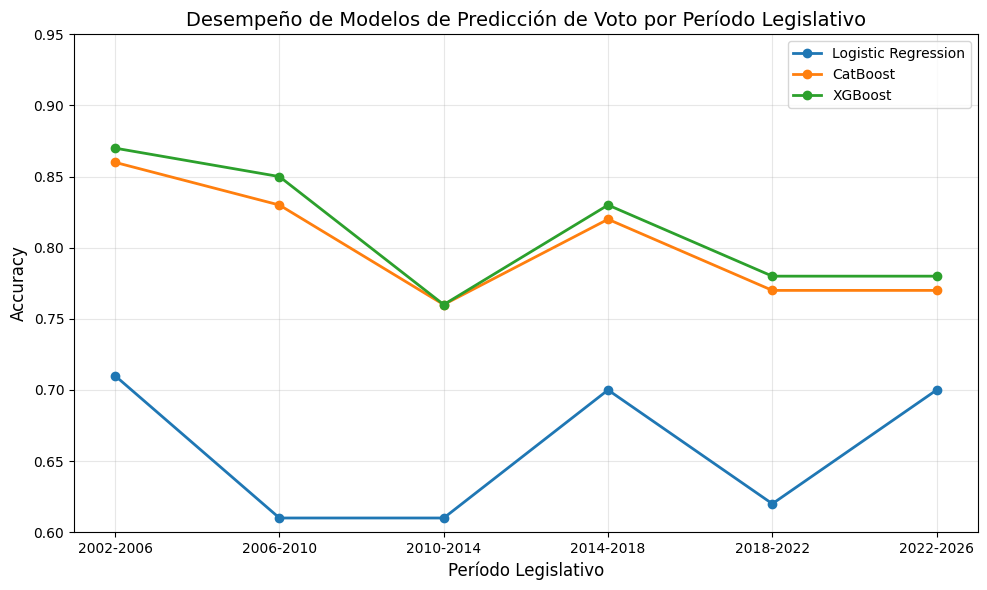

In [ ]:
plt.figure(figsize=(10, 6))

periodos = df_results["Periodo"].unique()  # eje X ordenado

for modelo in ["Logistic Regression", "CatBoost", "XGBoost"]:
    accuracies = df_results[df_results['Modelo'] == modelo]['accuracy'].values
    plt.plot(periodos, accuracies, marker="o", linewidth=2, label=modelo)

plt.title("Desempeño de Modelos de Predicción de Voto por Período Legislativo", fontsize=14)
plt.xlabel("Período Legislativo", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.60, 0.95)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Análisis de importancia de variables

Analizando período 2002-2006...


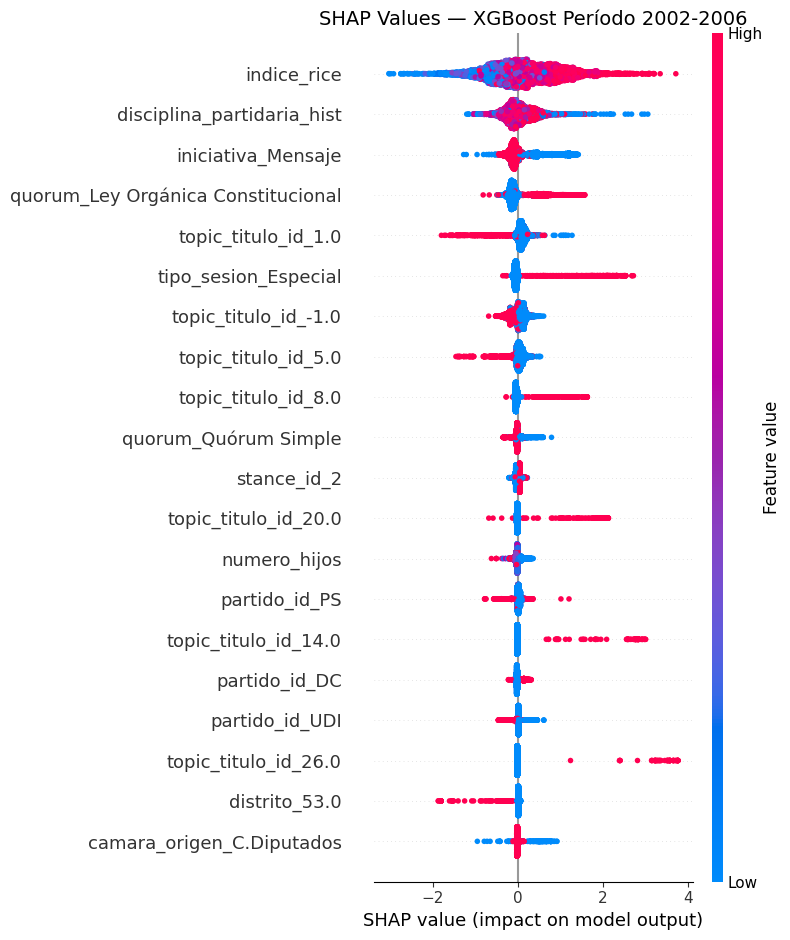

Analizando período 2006-2010...


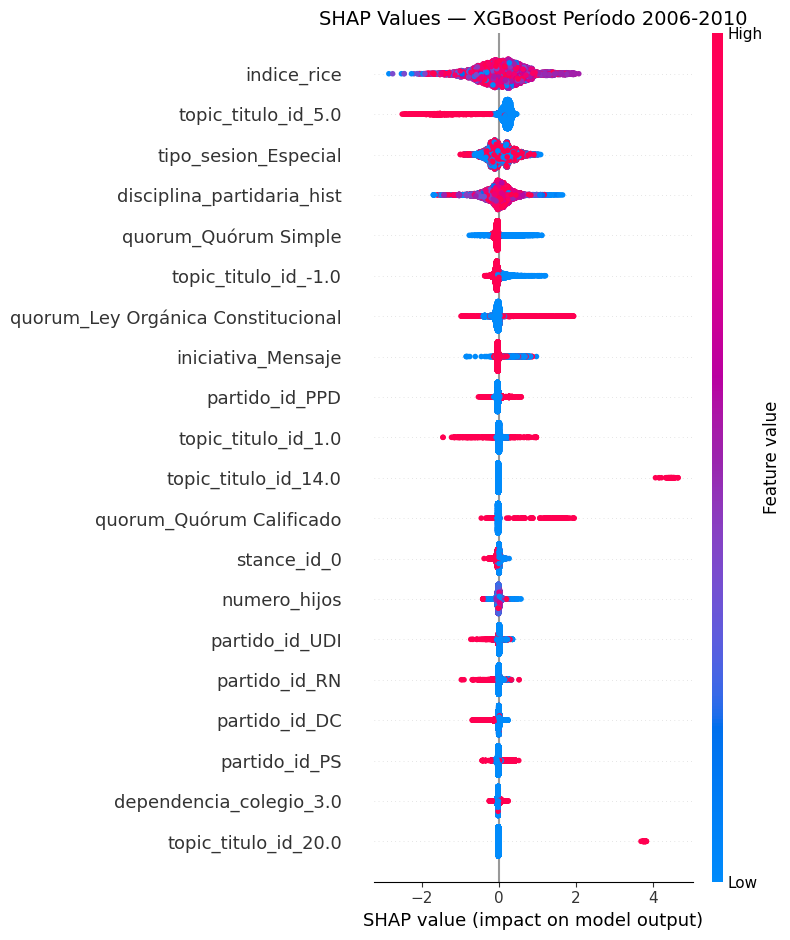

Analizando período 2010-2014...


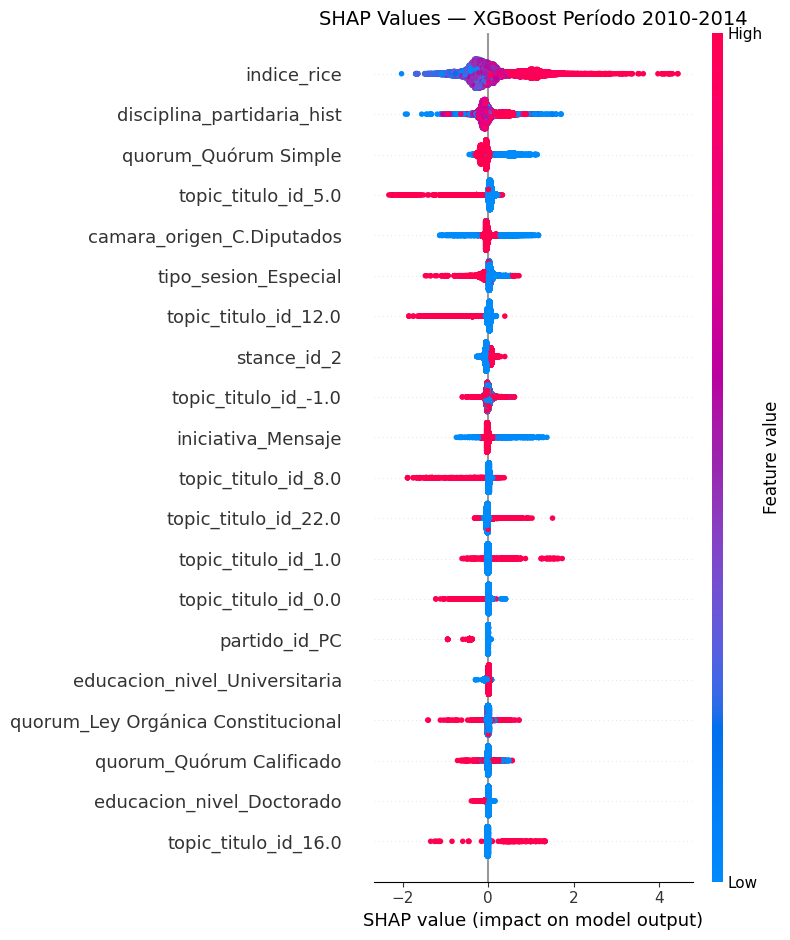

Analizando período 2014-2018...


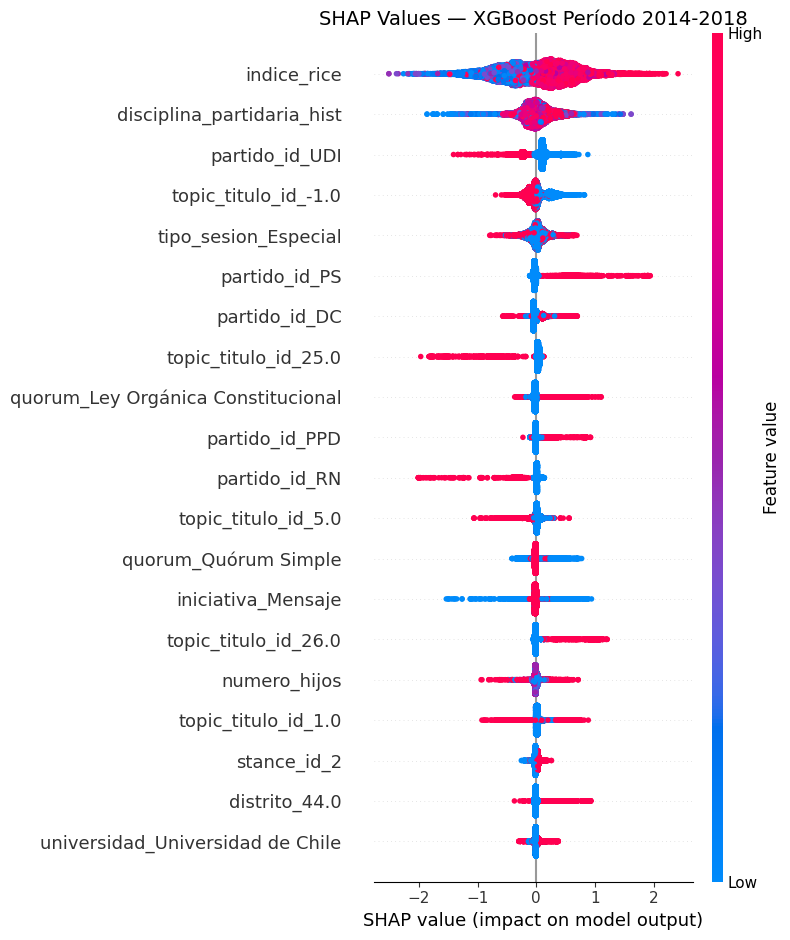

Analizando período 2018-2022...


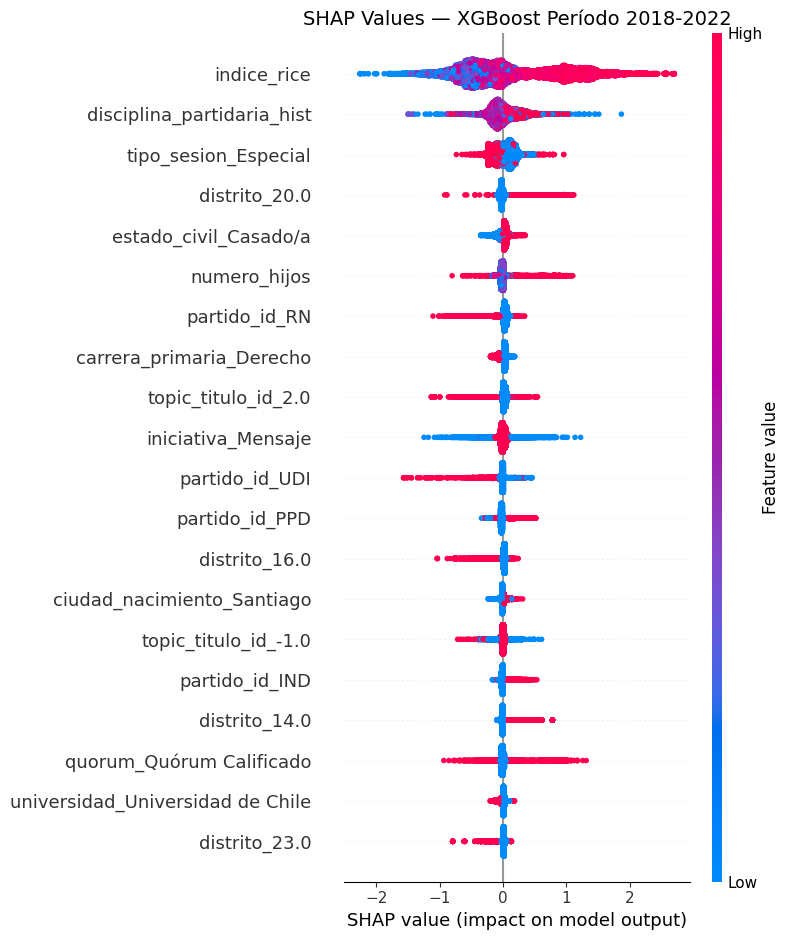

Analizando período 2022-2026...


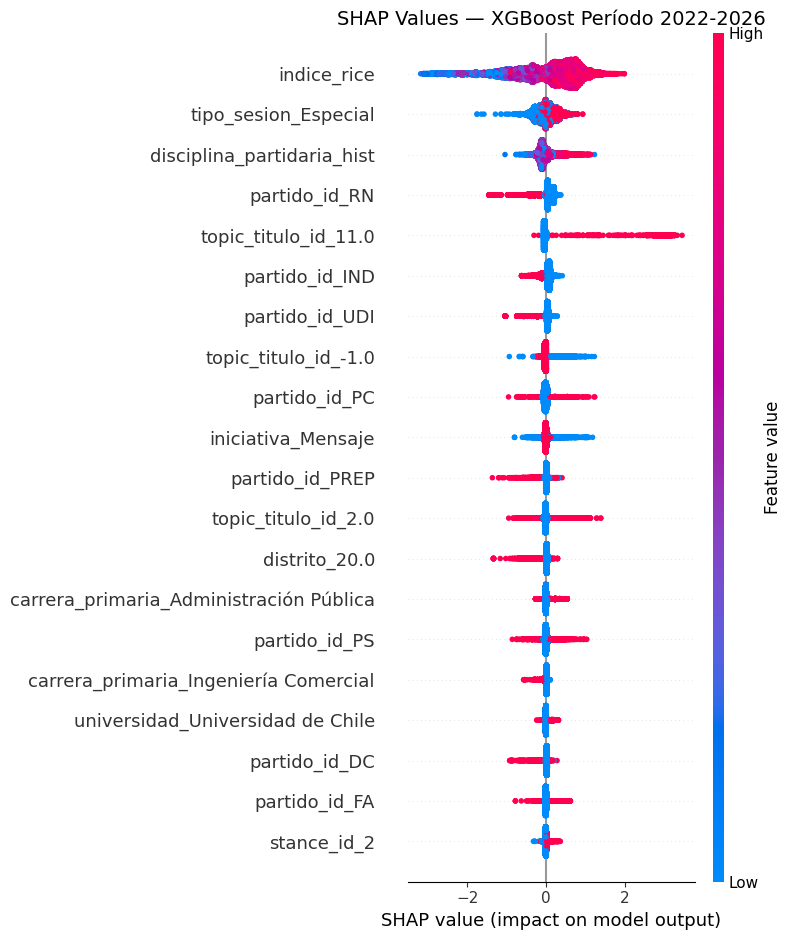

In [ ]:
import shap
import matplotlib.pyplot as plt

resultados_periodos = {}

for periodo in df_model["periodo"].unique():
    print(f"Analizando período {periodo}...")

    df_periodo = df_model[df_model["periodo"] == periodo]
    X = df_periodo.drop(["voto_valor"], axis=1)
    y = df_periodo["voto_valor"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pipe = pipelines["XGBoost"]
    pipe.fit(X_train, y_train)

    # Guardar métricas del período (opcional)
    preds = pipe.predict(X_test)
    resultados_periodos[periodo] = classification_report(y_test, preds)

    # Obtener modelo y nombres de variables
    preprocess = pipe.named_steps["preprocess"]
    feature_names = get_feature_names_from_column_transformer(preprocess)

    model = pipe.named_steps["model"]
    X_test_trans = pipe.named_steps["preprocess"].transform(X_test)

    # Convertir la matriz a DataFrame con nombres reales
    X_test_df = pd.DataFrame(
        X_test_trans.toarray() if hasattr(X_test_trans, "toarray") else X_test_trans,
        columns=feature_names
    )

    # === SHAP ===
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_trans)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_test_df,
        feature_names=X_test_df.columns,
        show=False
    )
    plt.title(f"SHAP Values — XGBoost Período {periodo}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
resultados_periodos = {}

for periodo in df_model["periodo"].unique():
    df_periodo = df_model[df_model["periodo"] == periodo]
    X = df_periodo.drop(["voto_valor"], axis=1)
    y = df_periodo["voto_valor"]
    print(y.shape)

(40452,)
(60832,)
(89563,)
(172864,)
(182704,)
(126813,)


## Entrenamiento por Tópicos

In [ ]:
df[df['topic_titulo_id'] == -1]['titulo'].drop_duplicates().to_list()

['Modifica diversas disposiciones relativas a la Zona Franca de Iquique.',
 'Posterga la vigencia del reavalúo de bienes raíces agrícolas y faculta al Presidente de la República para dictar texto refundido y actualizado que indica.',
 'Otorga un bono a los funcionarios públicos que indica.',
 'Ley de bases sobre contratos administrativos de suministro y prestación de servicios.',
 'Reajusta el Monto de Ingreso Mínimo Mensual.',
 'Tipifica y sanciona el acoso sexual.',
 'Modifica la ley N° 19.628, sobre protección de la vida privada para favorecer la reinserción laboral de las personas desempleadas',
 'Modifica la Ley sobre Alcoholes, Bebidas Alcohólicas y Vinagres, en lo relativo al consumo en la vía pública.',
 'Modifica la actual ley Orgánica de la Contraloría General de la República.',
 'Modifica la ley General de Cooperativas.',
 'Otorga bonificación anticipada a funcionarios de los Servicios de Salud y de las entidades que se mencionan.',
 'Crea Dirección Nacional de Cultura y el 

In [ ]:
df[['topic_titulo_id', 'topic_titulo_nombre']].drop_duplicates()

,topic_titulo_id,topic_titulo_nombre
0,12.0,12_pesca_acuicultura_artesanal_general
58,11.0,11_chile_carabineros_gendarmería_personal
344,1.0,1_constitucional_orgánica_electoral_18
416,-1.0,-1_ley_modifica_crea_establece
477,2.0,2_fondos_pensiones_tributario_tributaria
672,14.0,14_trabajo_código_trabajadores_laboral
749,13.0,13_monumento_autoriza_memoria_erigir
907,0.0,0_penal_delitos_código_delito
1317,NaN,None
2220,8.0,8_salud_sanitario_atención_servicios


In [ ]:
df_model = df.merge(df_stance, left_on=['boletin_id', 'nombre_completo'],
                    right_on=['boletin_inferido', 'nombre_dip'],
                    how='inner').rename(columns={'prediccion_titulo_id' : 'stance_id'})

In [ ]:
df_model['fecha_votacion'] = pd.to_datetime(df_model['fecha_votacion'], errors='coerce')
df_model = df_model.sort_values('fecha_votacion').reset_index(drop=True)

In [ ]:
df_model = df_model[['diputado_id',
              'indice_rice',
              'disciplina_partidaria_hist',
              'dependencia_colegio',
              'topic_titulo_id',
              'voto_valor',
              'quorum',
              'periodo', 'tipo_votacion', 'tipo_sesion',
              'partido_id',
              'rango_etario', 'estado_civil', 'numero_hijos', 'pais_nacimiento',
              'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
              'universidad_tipo', 'carrera_primaria',
              'iniciativa', 'camara_origen', 'etapa', 'stance_id']].copy()

In [ ]:
NUMERICAL_FEATURES = [
                      'indice_rice',
                      'disciplina_partidaria_hist'
                      ]

CATEGORICAL_FEATURES = ['quorum',
       'periodo', 'tipo_votacion', 'tipo_sesion',
       'partido_id', 'topic_titulo_id',
       'rango_etario', 'estado_civil', 'numero_hijos', 'pais_nacimiento',
       'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
       'universidad_tipo', 'carrera_primaria',
        'iniciativa', 'camara_origen', 'dependencia_colegio', 'stance_id']

In [ ]:
df_model.isna().sum().sort_values(ascending=False)

,0
numero_hijos,186786
educacion_nivel,52122
dependencia_colegio,50527
topic_titulo_id,43908
etapa,43908
camara_origen,43908
iniciativa,43908
tipo_sesion,14243
tipo_votacion,14243
indice_rice,9544


In [ ]:
df_model['numero_hijos_is_null'] = df_model['numero_hijos'].isna().astype(int)
df_model['numero_hijos'] = df_model['numero_hijos'].fillna(df_model['numero_hijos'].median())

In [ ]:
df_model = df_model.dropna()
df_model = df_model[df_model["voto_valor"].isin([0, 1])]
df_model = df_model[df_model["tipo_votacion"] == 'Particular']

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocesamiento = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES),
        ('num', StandardScaler(), NUMERICAL_FEATURES)
    ]
)

In [ ]:
from xgboost import XGBClassifier

models = {
    "XGBoost": XGBClassifier(scale_pos_weight=1)
}

In [ ]:
from sklearn.pipeline import Pipeline

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocess', preprocesamiento),
        ('model', model)
    ])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

resultados_topic = {}

for topic in [0, 2, 5, 8]:
    df_periodo = df_model[df_model["topic_titulo_id"] == topic]
    X = df_periodo.drop(["voto_valor"], axis=1)
    y = df_periodo["voto_valor"]

    # Dividir los datos en conjuntos de entrenamiento y prueba

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    results = {}

    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        results[name] = classification_report(y_test, preds)

    resultados_topic[topic] = results

In [ ]:
for topic in resultados_topic.keys():
    print(f"Resultados para el tópico {topic}:")
    for modelo, metricas in resultados_topic[topic].items():
        print(f"{modelo}:")
        print(metricas)

Resultados para el tópico 0:
XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.55      0.64       741
           1       0.87      0.95      0.91      2367

    accuracy                           0.85      3108
   macro avg       0.82      0.75      0.78      3108
weighted avg       0.85      0.85      0.85      3108

Resultados para el tópico 2:
XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1707
           1       0.91      0.91      0.91      3466

    accuracy                           0.88      5173
   macro avg       0.86      0.87      0.86      5173
weighted avg       0.88      0.88      0.88      5173

Resultados para el tópico 5:
XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      3730
           1       0.87      0.92      0.89      8470

    accuracy                           0.85     12200
   macro avg  

In [ ]:
import pandas as pd

resultados_xgb_topic = {
    0:  {"accuracy": 0.85, "macro_f1": 0.76, "weighted_f1": 0.85},
    2:  {"accuracy": 0.88, "macro_f1": 0.78, "weighted_f1": 0.86},
    5:  {"accuracy": 0.85, "macro_f1": 0.80, "weighted_f1": 0.84},
    8: {"accuracy": 0.88, "macro_f1": 0.74, "weighted_f1": 0.92},
}

df_topics = pd.DataFrame(resultados_xgb_topic).T
df_topics.index.name = "topico"
df_topics = df_topics.reset_index()

df_topics

,topico,accuracy,macro_f1,weighted_f1
0,0,0.85,0.76,0.85
1,2,0.88,0.78,0.86
2,5,0.85,0.80,0.84
3,8,0.88,0.74,0.92


/tmp/ipython-input-1866979715.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["Seguridad (0)", "Pensiones (2)", "Educación (5)", "Salud (8)"])


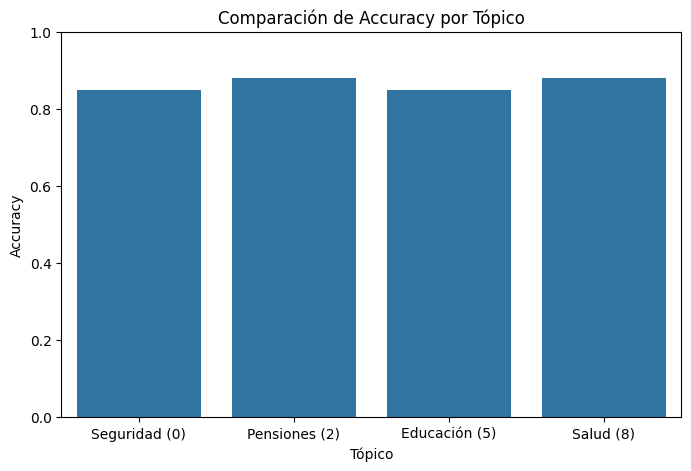

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.barplot(data=df_topics, x="topico", y="accuracy")
plt.gca().set_xticklabels(["Seguridad (0)", "Pensiones (2)", "Educación (5)", "Salud (8)"])
plt.ylim(0, 1)
plt.title("Comparación de Accuracy por Tópico")
plt.xlabel("Tópico")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def get_feature_names_from_column_transformer(ct):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        if name == "remainder":
            continue
        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)
    return feature_names

preprocess = pipe.named_steps["preprocess"]
feature_names = get_feature_names_from_column_transformer(preprocess)

Analizando tópico 0...
Tamaño de los datos: (15537,)


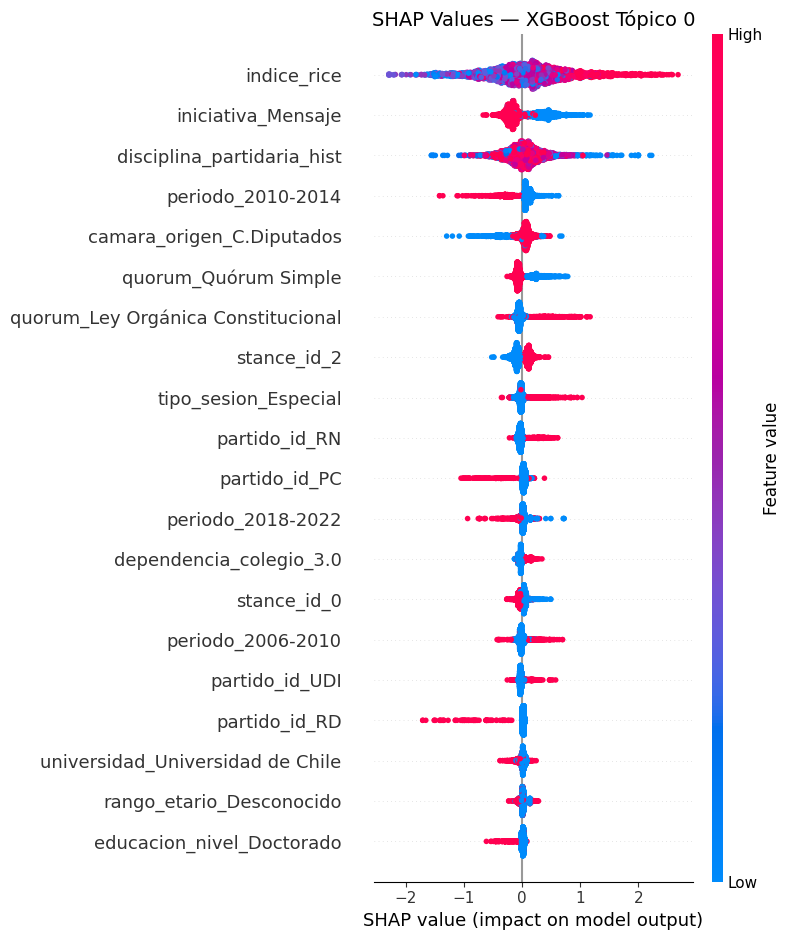

Analizando tópico 2...
Tamaño de los datos: (25864,)


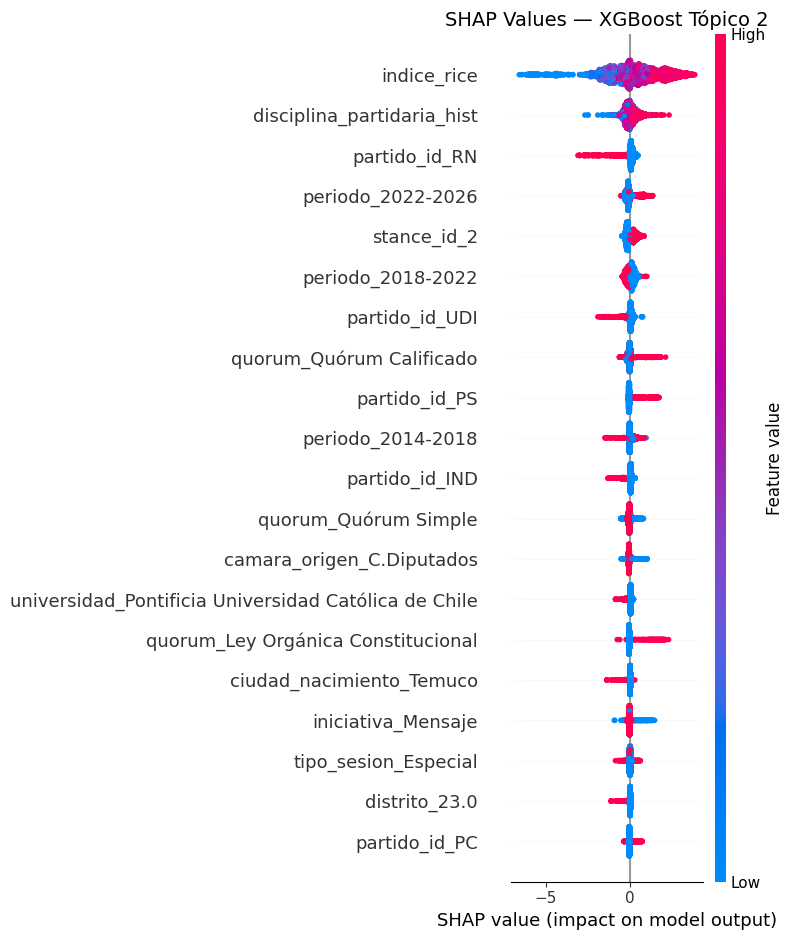

Analizando tópico 5...
Tamaño de los datos: (60999,)


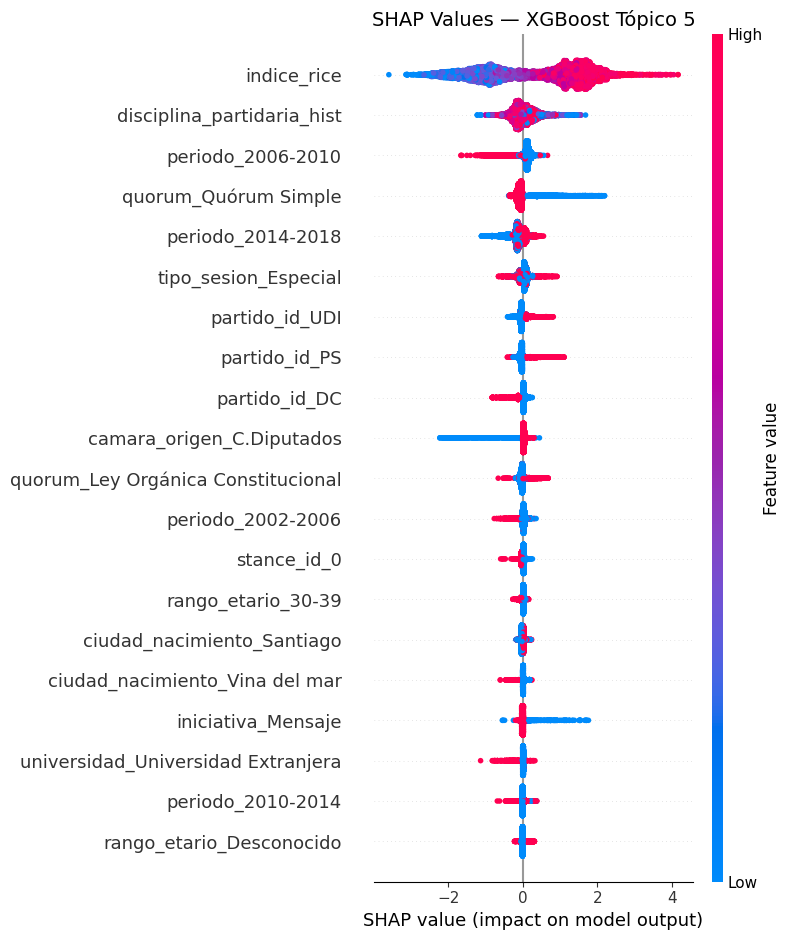

Analizando tópico 8...
Tamaño de los datos: (7664,)


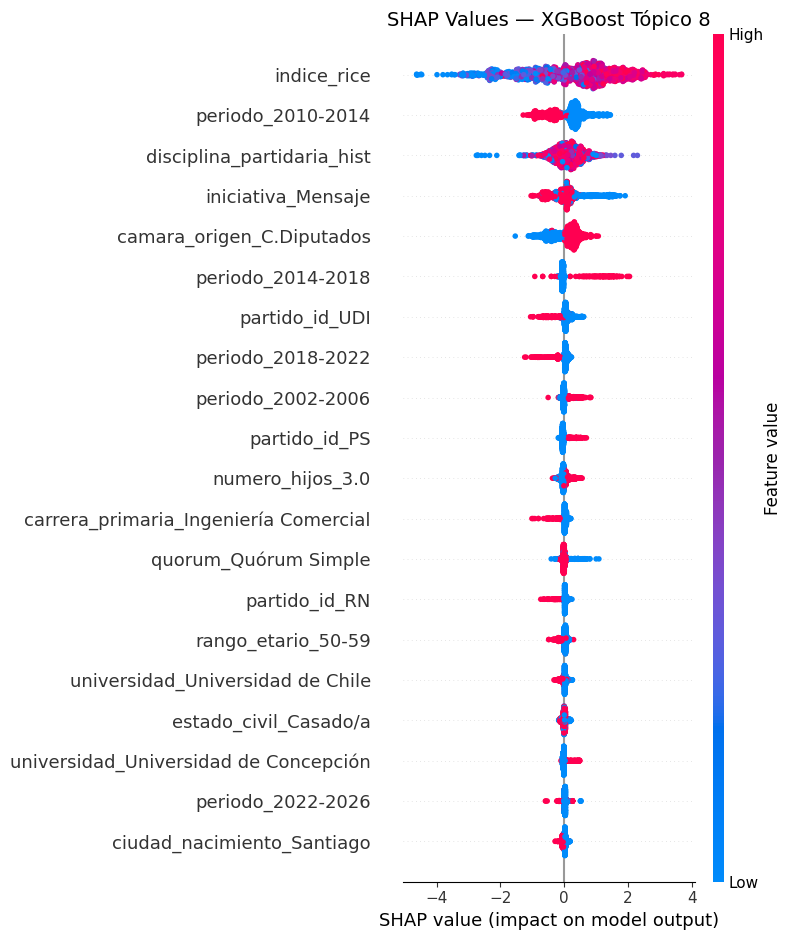

In [ ]:
import shap
import matplotlib.pyplot as plt

resultados_topic = {}

for topic in [0, 2, 5, 8]:
    print(f"Analizando tópico {topic}...")

    df_topic = df_model[df_model["topic_titulo_id"] == topic]
    X = df_topic.drop(["voto_valor"], axis=1)
    y = df_topic["voto_valor"]
    print(f"Tamaño de los datos: {y.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pipe = pipelines["XGBoost"]
    pipe.fit(X_train, y_train)

    # Guardar métricas del período (opcional)
    preds = pipe.predict(X_test)
    resultados_topic[topic] = classification_report(y_test, preds)

    # Obtener modelo y nombres de variables
    preprocess = pipe.named_steps["preprocess"]
    feature_names = get_feature_names_from_column_transformer(preprocess)

    model = pipe.named_steps["model"]
    X_test_trans = pipe.named_steps["preprocess"].transform(X_test)

    # Convertir la matriz a DataFrame con nombres reales
    X_test_df = pd.DataFrame(
        X_test_trans.toarray() if hasattr(X_test_trans, "toarray") else X_test_trans,
        columns=feature_names
    )

    # === SHAP ===
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_trans)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_test_df,
        feature_names=X_test_df.columns,
        show=False
    )
    plt.title(f"SHAP Values — XGBoost Tópico {topic}", fontsize=14)
    plt.tight_layout()
    plt.show()


## Random Forest

In [ ]:
df_model = df.merge(df_stance, left_on=['boletin_id', 'nombre_completo'],
                    right_on=['boletin_inferido', 'nombre_dip'],
                    how='inner')

In [ ]:
df_model['fecha_votacion'] = pd.to_datetime(df_model['fecha_votacion'], errors='coerce')
df_model = df_model.sort_values('fecha_votacion').reset_index(drop=True)

In [ ]:
df_model = df_model[['diputado_id',
              'indice_rice',
              'disciplina_partidaria_hist',
              'dependencia_colegio',
              'topic_titulo_id',
              'voto_valor',
              'quorum',
              'periodo', 'tipo_votacion', 'tipo_sesion', 'tramite',
              'informe', 'partido_id',
              'rango_etario', 'estado_civil', 'numero_hijos', 'pais_nacimiento',
              'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
              'universidad_tipo', 'carrera_primaria',
              'iniciativa', 'camara_origen', 'etapa', 'prediccion_titulo_id']].copy()

In [ ]:
NUMERICAL_FEATURES = ['diputado_id',
                      'indice_rice',
                      'disciplina_partidaria_hist',
                      'dependencia_colegio',
                      'topic_titulo_id',
                      'prediccion_titulo_id'
                      ]

CATEGORICAL_FEATURES = ['quorum',
       'periodo', 'tipo_votacion', 'tipo_sesion', 'tramite',
       'informe', 'partido_id',
       'rango_etario', 'estado_civil', 'numero_hijos', 'pais_nacimiento',
       'ciudad_nacimiento', 'distrito', 'educacion_nivel', 'universidad',
       'universidad_tipo', 'carrera_primaria',
        'iniciativa', 'camara_origen', 'etapa']

In [ ]:
df_model.isna().sum().sort_values(ascending=False)

,0
numero_hijos,186786
educacion_nivel,52122
dependencia_colegio,50527
camara_origen,43908
etapa,43908
topic_titulo_id,43908
iniciativa,43908
tramite,14243
tipo_votacion,14243
informe,14243


In [ ]:
df_model['numero_hijos_is_null'] = df_model['numero_hijos'].isna().astype(int)
df_model['numero_hijos'] = df_model['numero_hijos'].fillna(df_model['numero_hijos'].median())

In [ ]:
df_model = df_model.dropna()
df_model = df_model[df_model["voto_valor"].isin([0, 1])]
df_model = df_model[df_model["tipo_votacion"] == 'Particular']

In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop(["voto_valor"], axis=1)
y = df_model["voto_valor"]

# Dividir los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocesamiento = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES),
        ('num', StandardScaler(), NUMERICAL_FEATURES)
    ]
)

In [ ]:
from cuml.ensemble import RandomForestClassifier

models = {
    "Random Forest" : RandomForestClassifier(
    n_estimators=500,
    max_depth=18,
    n_streams=8,
    bootstrap=True,
    max_features="sqrt"
)
}

In [ ]:
from sklearn.pipeline import Pipeline

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocess', preprocesamiento),
        ('model', model)
    ])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

results = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results[name] = classification_report(y_test, preds)


In [ ]:
print(results['Random Forest'])

              precision    recall  f1-score   support

           0       0.73      0.12      0.20     37488
           1       0.74      0.98      0.85     97158

    accuracy                           0.74    134646
   macro avg       0.74      0.55      0.52    134646
weighted avg       0.74      0.74      0.67    134646

